<a href="https://colab.research.google.com/github/Kang-Yoonah/BigAi/blob/gh-pages/3/HandsOn/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7장. 앙상블 학습과 랜덤 포레스트

일련의 예측기(즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있다.   
일련의 예측기를 **앙상블**이라고 부르기 때문에 이를 **앙상블 학습**이라고 하며, 앙상블 학습 알고리즘을 **앙상블 방법**이라고 한다.

예를 들어,   
훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킨다.   
예측 하기 위해선 모든 개별 트리의 예측을 구하여 가장 많은 선택을 받은 클래스를 예측으로 삼는다.   
이런 결정트리의 앙상블을 **랜덤 포레스트**라고 한다.

**배깅, 부스팅, 스태킹**과 같은 앙상블 방법이 있다.

## 설정

In [38]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 7.1 투표기반 분류기 (Voting 분류기)

**앙상블 밑바탕이 되는 생각**
- 각 분류기가 Weak Learner 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 Strong Learner 강한 학습기가 될 수 있다.   
다시 말해서, 상대적으로 약한 여러 개의 학습기를 결합해 단일 분류기보다 신뢰성이 높은 예측값을 얻는 것을 목표로 한다.

**분류기 종류1**
- 보팅 Voting 분류기
    - 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식
    - 같은 훈련 데이터에 대해 학습하고 예측한 결과를 투표하려 최종 예측 결과를 선정하는 방식이다.
    - Hard Voting 분류기
        - 각 분류기의 예측을 모아서 다수결 투표로 클래스를 예측하는 분류기
        - 이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다 정확도가 높을 경우가 많다.
    - Soft Voting 분류기
        - 각각의 분류기들의 클래스의 결정 확률을 모두 더하고 평균하여 가장 높은 클래스를 최종 보팅 결괏값으로 선정
        - 모든 분류기가 클래스의 확률을 추정할 수 있어야 한다.
        - 확률이 높은 투표에 비중을 더 두기 때문에 Hard Voting 방식보다 성능이 더 높다.
        - 일반적으로 더 많이 사용되는 방식이다.
    - 보팅을 한다고해서 항상 성능이 올라가진 않지만, 단일 ML 알고리즘보다 뛰어는 예측 성능을 가지는 경우가 많다.



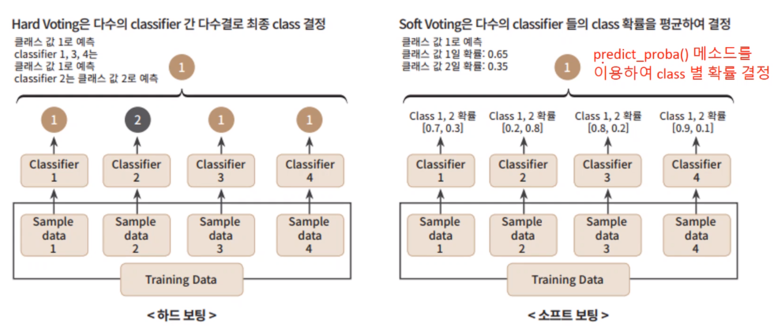

In [39]:
from scipy.stats import binom

print('51% 정확도를 가진 1,000개의 분류기로 예측할 때의 정확도')
print(1 - binom.cdf(499,1000,0.51))
print()
print('10,000개의 분류기로 예측할 때의 정확도')
print(1 - binom.cdf(4999,10000,0.51))

51% 정확도를 가진 1,000개의 분류기로 예측할 때의 정확도
0.7467502275563249

10,000개의 분류기로 예측할 때의 정확도
0.9777976478701103


In [40]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

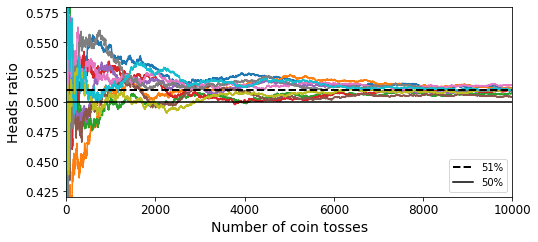

In [41]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

결과
- 큰 수의 법칙
    - 사건을 무한히 반복할 때 일정한 사건이 일어나는 비율은 횟수를 거듭하면 할수록 일정한 값에 가까워지는 법칙
- 동전을 던졌을 때 앞면이 51%, 뒷면이 49%가 나오는 균형이 맞지 않는 동전을 던진다고 가정하자.   
더 많이 던질수록 앞면이 나올 확률은 증가한다.   
즉, 계속해서 던질수록 앞면이 나오는 비율은 점점 더 앞면이 나올 확률(51%)에 가까워진다.
- 위의 그림은 균형이 틀어진 동전을 10번 실험한 그래프이다.   
10번의 실험 모두 50%보다 높게 유지되며 큰 수의 법칙에 의해 51%에 수렴하면서 끝나고 있다.   
 **따라서 앞면이 다수가 될 확률은 던지는 횟수를 거듭할 수록 높아진다.**

*moons 데이터셋을 사용하여 VotingClassifier 훈련하기 : Hard Voting*

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# VotingClassifier 모델
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [44]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [45]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**결과**
- 투표 기반 분류기가 다른 개별 분류기보다 성능이 더 높다.
- 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다.   
다양한 분류기를 얻는 방법은 각기 다른 알고리즘으로 학습시키는 것이다.   
그럼 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다.   
반면 분류기들이 서로 종속적이라면 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아진다.

*VotingClassifier 훈련하기 : Soft Voting*

In [46]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)   # proba를 True로 변경해준다.

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [47]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 7.2 배깅과 페이스팅

**분류기 종류2**
- 배깅 Bagging 분류기
    - 각각의 분류기가 모두 같은 유형의 알고리즘 기반이며, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 Voting을 수행하는 것이다.
    - 대표적으로 랜덤 포레스트가 있다.
    - **Bootstrap**
        - Train Data에서 여러 번 복원 추출하는 Random Sampling 기법(데이터 일부가 중첩됨)
            - 중복 허용하여 샘플링 : 배깅
            - 중복을 허용하지 않고 샘플링 : 페이스팅
            - 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다.
                - 예측값들과 정답이 대체로 멀리 떨어져 있으면 결과의 편향이 높다.
                - 예측값들이 자기들끼리 대체로 멀리 흩어져 있으면 결과의 분산이 높다.
            - 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 
               - 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호한다. 
               - 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 선택하는 것이 좋다. 
        - 추출된 샘플들을 부트스트랩 샘플이라 부른다.
        - 이론적으로 36.8%의 샘플이 뽑히지 않게 된다. 이를 Out-Of-Bag 샘플이라고 한다.
        - Out-Of-Bag (OOB) 샘플의 사용
            - Test Data로서 사용할 수 있다.

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.
- 수집 함수
   - 분류 : 통계적 최빈값(즉, 직접 투표 분류기처럼 가장 많은 예측 결과)
   - 회귀 : 평균을 계산한다.
- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만(데이터가 적으므로)     
수집 함수를 통과하면 편향과 분산이 모두 감소한다. 
- 일반적으로는 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬때와 비교해 편향은 비슷하지만 분산은 줄어든다.



- 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있다.
- 이와 유사하게 예측도 병렬로 수행할 수 있다.

## 7.2.1 사이킷런의 배깅과 페이스팅

*BaggingClassifier 사용*

In [48]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,    
    max_samples=100, bootstrap=True, random_state=42)
    # n_estimators=500 : 결정트리 분류기 500개의 앙상블    
    # max_samples=100, bootstrap=True : 각 분류기는 훈련세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련 
    # max_samples 매개변수는 0.0 ~ 1.0 사이의 실수로 지정할 수도 있다.(이렇게 하면 훈련세트의 비율로 할 수 있다.)
    # n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정한다. (-1로 지정하면 가용한 모든 코어를 사용), 기본값은 1
    # BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(즉, predict_proba() 함수가 있으면)
    #    직접 투표 대신 자동으로 간접 투표 방식을 사용한다. 
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [49]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [50]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [51]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

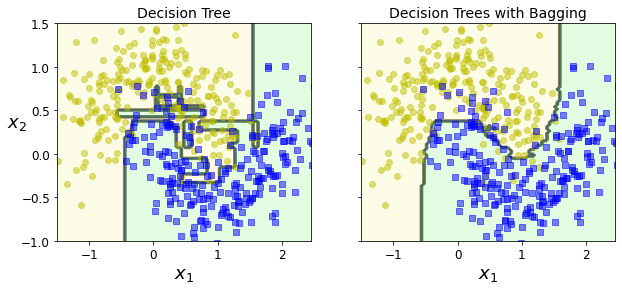

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

- 결과
   - 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 잘 된다.
   - 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.   
   (훈련세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙하다.) 


## OOB 평가

- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다.
- BaggingClassifier는 기본값으로 중복을 허용하여(bootstrap = True) 훈련 세트으 크기만큼인 m개 샘플을 선택한다. 
    - 이는 평균적으로 각 예측기에 훈련샘플의 63%(수학적인 계산) 정도만 샘플링된다는 것을 의미한다. 
    - 선택되지 않은 훈련 샘플 37% 를 **oob(out-of-bag) 샘플**이라고 부른다
       - 예측기마다 남겨진 37%는 모두 다르다.
- 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다.
- 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다. 
- 사이킷런에서 BaggingClassifier를 만들 때 oob_score = True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다.    

In [53]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [54]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

- 결과 
    - oob 평가 점수와 테스트 세트의 정확도가 비슷하다 .

In [55]:
# oob 샘플에 대한 결정 함수의 값도 확인 가능 
bag_clf.oob_decision_function_[:5]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

# 7.3 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier는 특성 샘플링도 지원한다. 
    - 샘플링은 max_samples, bootstrap_features 두 매개변수로 조절된다. 
        - 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링이다. 
        - 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다. 
- 이 기법은 특히 (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용하다.

- 랜덤 패치 방식 
    - 훈련 특성과 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식
    - 훈련 샘플을 모두 사용하고(bootstrap = False이고 max_samples = 1.0로 설정)   
    특성은 샘플링하는(bootstrap_featurs = True 그리고/또는 max_features는 1.0보다 작게 설정) 

- 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다. 

#7.4 랜덤 포레스트

- 랜덤포레스트
    - 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블이다. 
    - 전형적으로 max_samples를 훈련 세트의 크기로 지정한다. 

In [56]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [57]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [58]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [59]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일합니다.

1.0

- RandomForestClassifier는 몇 가지 예외가 있지만 (트리 성장의 조절을 위한) Decision Tree Classifier의 매개변수와 앙상블 자체를 제어하는 데 필요한 BaggingClassifier의 매개변수를 모두 가지고 있다. 
- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다. 
    - 트리를 더욱 다양하게 만들고 (다시 한번) 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭항 모델을 만든다. 

##7.4.1 엑스트라 트리

- 트리를 더욱 무작위하게 만들기 위해 (보통의 결정 트리처럼) 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택한다. 
- 이와 같이 극단적으로 무작위한 트리의 맨덤 포레스트를 **익스트림 랜덤트리** 앙상블(또는 줄여서 **엑스트라 트리**)이라고 부른다. 
    - 편향이 늘어나지만 대신 분산을 낮춘다. 
    - 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가  
- 사이킷런의 ExtraTreesClassifier를 사용한다.
    - 사용법은 RandomForestClassifier과 같다. 
    - 마찬가지로 ExtraTreesRegressor도 RandomForestRegressor와 같은 API를 제공한다. 

##7.4.2 특성 중요도

**랜덤 포레스트의 장점2**
- 특성의 상대적 중요도를 측정하기 쉽다.
    - 사이킷런은 어떤 특성을 사용한 노드가 (랜덤포레스트에 있는 모든 트링 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정 
    - 더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같다. 
    - 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏갓을 정규화한다.
        - 이 값은 feature_importances_ 변수에 저장도어 있다.

In [60]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [61]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

*15개 결정 트리의 결정 경계 중첩한 그림*

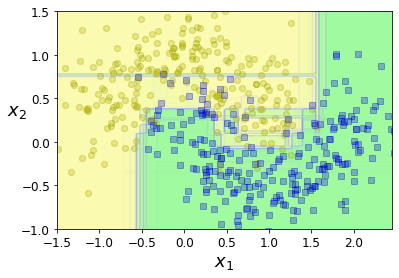

In [62]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

**결과**
- 개별 결정 트리는 불완전하지만 앙상블되면 매우 좋은 결정 경계를 만든다.

*랜덤 포레스트 분류기에서 얻은 MNIST 픽셀 중요도*

In [63]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

KeyboardInterrupt: ignored

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

#7.5 부스팅

**분류기 종류3**
- 부스팅
    - 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
    - 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
    - 에이다부스트, 그레이디언트 부스팅, XGBoosting 등이 있다.
    - 단점
        - 연속하여 모델을 학습해야하기 때문에 병렬화되지 못한다.


**배깅과 부스팅의 차이점**
- 배깅
    - 병렬 앙상블 모델 : 각 모델은 서로 독립적
    - 목적 : Variance 감소
    - 적합한 상황 : 복잡한 모델 (High Variance, Low Bias)
- 부스팅
    - 연속 앙상블 모델 : 이전 모델의 오류를 고려
    - 목적 : Bias 감소
    - 적합한 상황 : Low Variance, High Bias 모델
- 배깅에서 데이터를 단순히 샘플링해서 각 모델에 적용한다면,   
부스팅은 이전 모델들이 예측하지 못한 Error 데이터에 가중치를 부여하여   
다음 모델이 더 잘 예측하도록 한다.

## 7.5.1 에이다부스트

- 이전 모델이 놓친 샘플에 가중치를 크게 부여하여 다시 학습한다.
- 기대효과 : 새로운 예측기가 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.
- 과정
    1. 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만든다.
    2. 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
    3. 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.
    4. 다시 가중치를 업데이트하는 식으로 계속된다.
- 경사하강법과의 비교
    - 연속된 학습 기법이라는 점에서 비슷하다.
    - 경사하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가지만   
    에이다부스트는 점차 더 좋아지도록 앙상블에 예측을 추가한다.
- 최종 예측 계산법
    - 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라   
    예측기마다 다른 가중치가 적용된다.
    - 예측기가 정확할수록 예측기의 가중치가 더 높아지게 된다.
    - 샘플의 가중치를 업데이트하고 정규화한 이후 새로운 예측기가   
    업데이트된 샘플 가중치를 사용해 훈련된다.
    - 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지된다.
    - *예측* : 모든 예측기의 예측을 계산하고 예측기 가중치를 더해 예측 결과를 만든다.   
    결과 중에서 가중치 합이 가장 큰 클래스가 예측 결과가 된다.

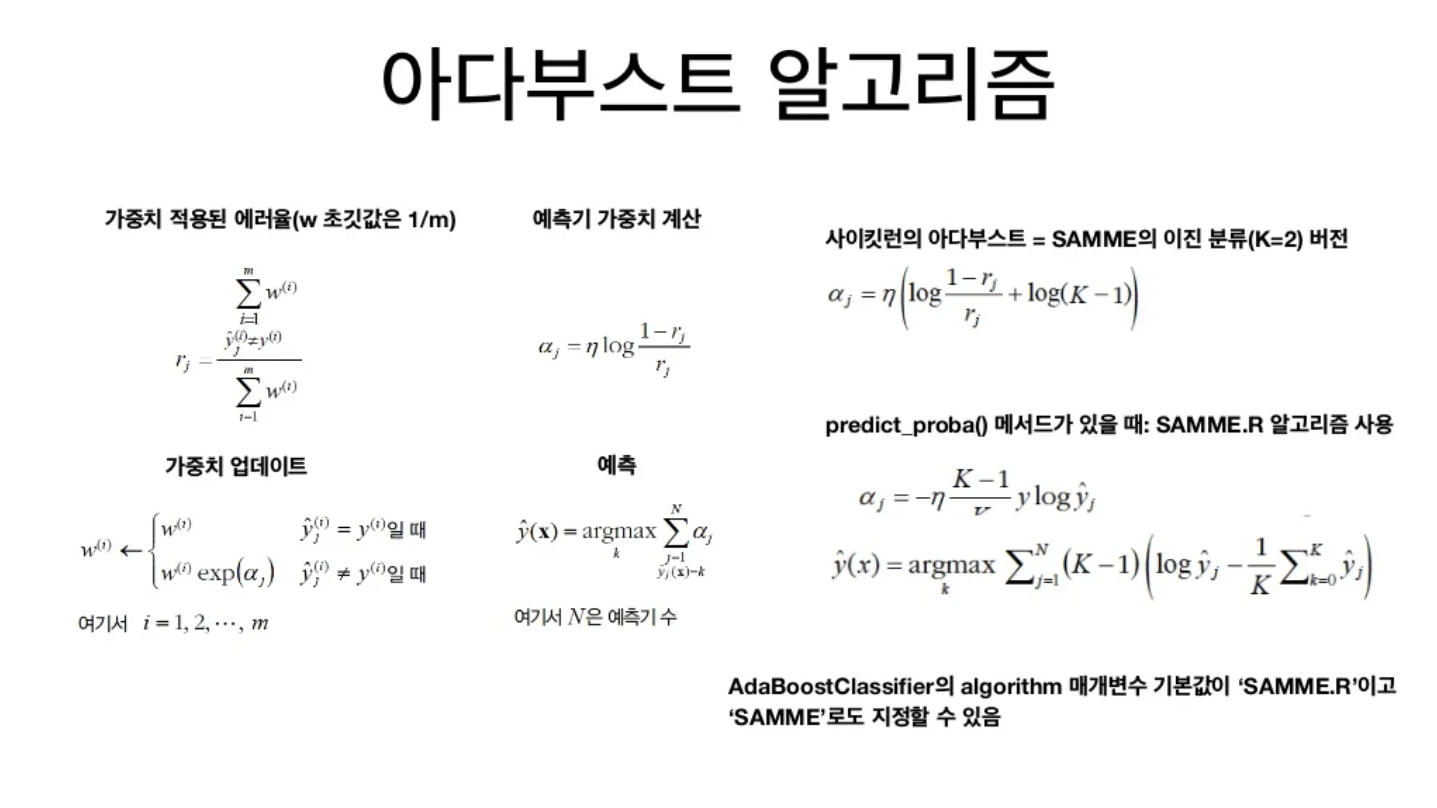

출처 : https://www.slideshare.net/RickyPark3

- 사이킷런에서는 SAMME라는 에이다부스트의 다중 클래스 버전을 사용한다.   
클래스가 두 개 뿐일때는 에이다부스트와 동일하다.
- 만약 예측기가 클래스의 확률을 추정할 수 있다면,   
SAMME.R이라는 SAMME의 변종을 사용한다.
    - 이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋다.

*사이킷런의 AdaBoostClassifier를 사용하여 훈련*
- 200개의 아주 얕은 결정트리 기반 에이다부스트 분류기

In [64]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME.R", 
    learning_rate=0.5, 
    random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

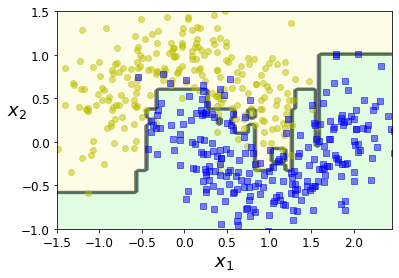

In [65]:
plot_decision_boundary(ada_clf, X, y)

In [66]:
y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)    # 배깅은 0.912 였음.

0.896

*연속된 예측기의 결정 경계 확인*

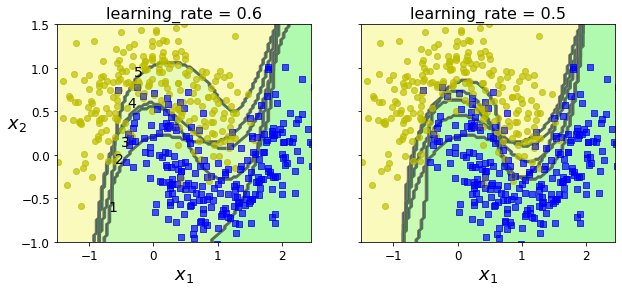

In [67]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 0.6), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)     # SVC 모델 사용
        svm_clf.fit(X_train, y_train, sample_weight = sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1 : 에러율
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2 : 예측기 가중치
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3 : 샘플 가중치 업데이트
        sample_weights /= sample_weights.sum() # normalization step : 샘플 가중치 모두 정규화
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)   # 결정경계 그리기
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)   
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")
plt.show()

## 7.5.2 그레이디언트 부스팅

- 기본 개념은 AdaBoost와 동일하고 가중치를 계산하는 방식에서   
Loss Function의 Gradient를 통해 오답에 가중치 부여
- **이전의 예측기가 만든 잔여 오차를 학습**
- 결정 트리를 기반 예측기로 사용하는 그레이디언트 부스팅 : GBM 그레이디언트 트리 부스팅
- 최종 예측
    - *예측* : 새로운 샘플에 대한 모든 트리의 예측을 더하면 된다.
- `subsample` 매개변수 : 각 트리가 훈련할 때 사용할 훈련 샘플의 비율 지정
    - 예를 들어 0.25라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됨.
    - 편향은 높아지고 분산은 낮아진다.
    - 훈련 속도를 상당히 높인다.

*간단히 데이터셋 만들어서 구현해보기*

In [68]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [69]:
from sklearn.tree import DecisionTreeRegressor

# 첫 번째 예측기로 훈련
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [70]:
# 잔여 오차에 대해 두 번째 예측기로 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [71]:
# 두 번째 잔여 오차에 대해 세 번째 예측기로 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [72]:
# 새로운 데이터
X_new = np.array([[0.8]])

# 모든 예측기의 예측값을 더한다.
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.75026781]


*세 트리의 예측과 앙상블 모델의 예측*

In [73]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

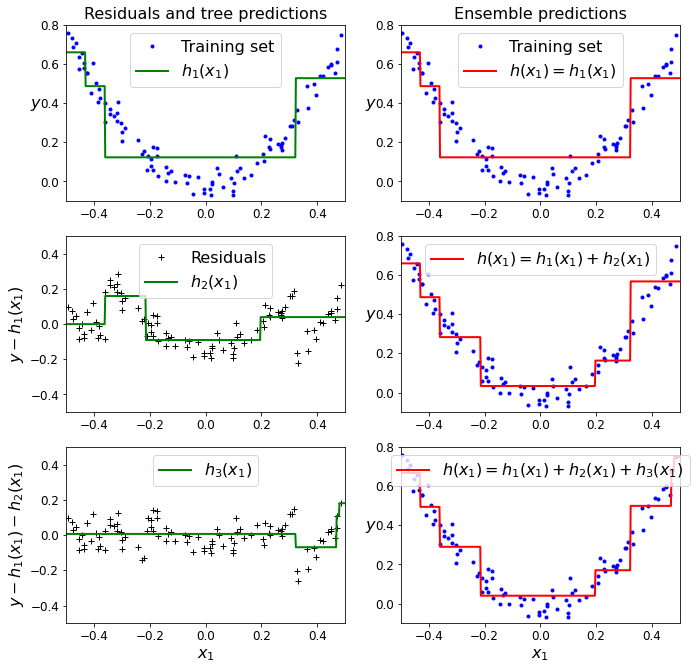

In [74]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

**결과**
- 앙상블에 트리가 추가될수록 앙상블의 예측이 점차 좋아진다.
- 즉, 편향은 낮아지고 분산은 높아진다.

*사이킷런의 GBR 사용*

In [75]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

*Learning_rate와 예측기의 수 비교*
- `learning_rate` 매개변수
    - 각 트리의 기여 정도를 조절한다.
    - **축소** 규제
        - 매개변수 값을 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하다.   
    하지만 일반적으로 예측의 성능은 더 좋아진다.


In [76]:
gbrt_less = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt_less.fit(X, y)

gbrt_more = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_more.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

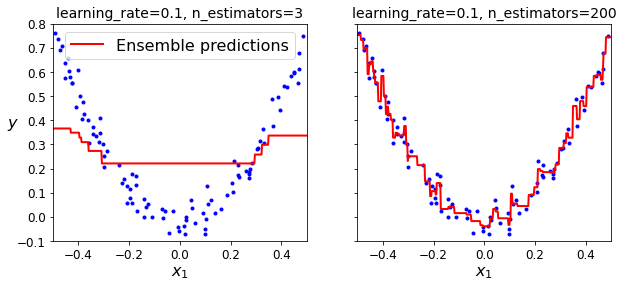

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt_less], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_less.learning_rate, gbrt_less.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_more], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_more.learning_rate, gbrt_more.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

**결과**
- 작은 학습률로 훈련시킨 두 개의 GBRT 앙상블
- 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않음.
- 오른쪽은 트리가 너무 많아서 훈련 세트에 과대적합 됨.

*조기 종료를 사용한 그래디언트 부스팅*
- 방법1 : staged_predict() 메서드 사용


In [78]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 데이터 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# 모델 설정
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# staged_predict() 메서드 : 앙상블에 의해 만들어진 예측기를 순회하는 반복자 반환
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1    # 가장 작게 하는 갯수 = 최적의 트리 수

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

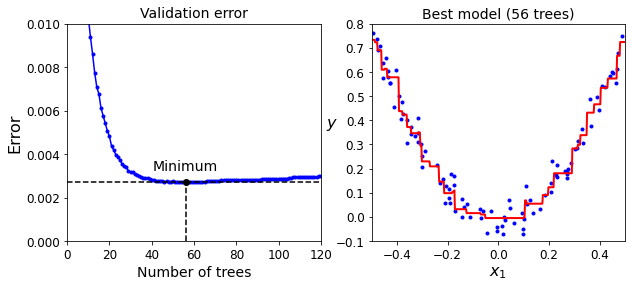

In [79]:
min_error = np.min(errors)

plt.figure(figsize=(10, 4))

# 트리 수에 따른 오차 나타내기
plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

# 최적의 트리 수를 가진 앙상블로 훈련한 결과
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

- 방법2 : 훈련 중지하는 방법
    - 많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾기 위해 살펴보지 않고   
    연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련 중지
    - `warm_start = True`로 설정하면 `fit()` 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 함.

In [88]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators    # 모델의 n_estimators 설정
    gbrt.fit(X_train, y_train)    # 그때그때마다 훈련시킴. 근데 warm_start=True 이기 때문에, 기존 트리를 유지하며 훈련 추가.
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if n_estimators == 57:
        print(val_error)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        if n_estimators > 55:
            print(n_estimators, y_pred)
        error_going_up += 1
        if error_going_up == 5:
            break  # 5번 연속해서 오르지 않는다면 조기 종료

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=False, random_state=42)
gbrt.n_estimators = 57
gbrt.fit(X_train,y_train)
y_pred = gbrt.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print(gbrt.n_estimators)
print("Minimum validation MSE:", val_error)
print('warm_start = True는 가중치를 유지하고 추가된 트리만큼 훈련을 더한 것임.')

0.002719454272122578
57 [ 0.18056827  0.18056827 -0.00488566  0.18056827  0.05461298 -0.00488566
 -0.00488566  0.09818962  0.60981508  0.57376612  0.37205591  0.2832208
  0.37205591  0.01557074  0.57782888  0.09818962  0.12265572  0.03185574
  0.57782888 -0.00488566  0.18056827  0.57782888  0.22968091  0.4375223
  0.66788381]
58 [ 0.18089288  0.18089288 -0.00626894  0.18089288  0.05493759 -0.00626894
 -0.00626894  0.0984301   0.61005556  0.57409073  0.37229639  0.28354541
  0.37229639  0.01418746  0.57806936  0.0984301   0.12298033  0.03614512
  0.57806936 -0.00626894  0.18089288  0.57806936  0.22992138  0.43776278
  0.66820842]
59 [ 0.18086776  0.18086776 -0.00629406  0.18086776  0.05491248 -0.00629406
 -0.00629406  0.09840498  0.60649835  0.57406561  0.37227127  0.2835203
  0.37227127  0.01416235  0.57804424  0.09840498  0.12295521  0.03612
  0.57804424 -0.00629406  0.18086776  0.57804424  0.22989627  0.43773766
  0.6681833 ]
60 [ 0.18113035  0.18113035 -0.00815011  0.18113035  0.055

**XGBoost 사용하기**

In [81]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [82]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음

[10:50:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [83]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

[10:50:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

In [84]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[10:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [85]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 5: 22.5 ms per loop


# 7.6 스태킹

**분류기 종류3**
- 스태킹
    - 아이디어 : 앙상블에 속한 모든 예측기의 예측을 취합하는데 이를 취합하는 모델을 훈련시켜 사용하자.
    - **블렌더**
        - 마지막 예측기
        - 이전의 층에서의 예측기들의 예측들을 입력으로 받아 최종 예측을 만든다.
        - 학습 방법
아**분류기 종류3**
- 스태킹
    - 아이디어 : 앙상블에 속한 모든 예측기의 예측을 취합하는데 이를 취합하는 모델을 훈련시켜 사용하자.
    - **블렌더**
        - 마지막 예측기
        - 이전의 층에서의 예측기들의 예측들을 입력으로 받아 최종 예측을 만든다.
        - 학습 방법
우- 스태킹
    - 아이디어 : 앙상블에 속한 모든 예측기의 예측을 취합하는데 이를 취합하는 모델을 훈련시켜 사용하자.
    - **블렌더**
        - 마지막 예측기
        - 이전의 층에서의 예측기들의 예측들을 입력으로 받아 최종 예측을 만든다.
        - 학습 방법
            - 홀드 아웃 세트 활용
            1. 훈련 세트를 2개의 서브셋으로 만든다.
            2. 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용한다.
            3. 훈련된 첫 번째 레이어의 예측기를 사용해 두 번째 훈련 서브셋 데이터에 대해 예측을 만든다.
            4. 홀드 아웃 세트의 각 샘플에 대한 각 모델의 예측값들을 입력 특성으로 사용한다.   
            즉, 타깃값은 그대로 쓰고 앞에서 예측한 값을 특성으로 사용하는 새로운 훈련 세트를 만든다.
            5. 이 데이터를 **훈련 세트 블렌딩**이라고 하고 이것이 블렌더의 훈련 세트가 된다.